In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt 
from PIL import Image, ImageOps
import pandas as pd
import csv

import torch
from torchvision import transforms
from torch import nn
import torch.nn.functional as F

from itertools import groupby
import utils
from get_model import CRNN_GRU

from tqdm import tqdm

In [2]:
train_path = 'recog_data/data/training_data'
test_path = 'IIIT5K/train'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
char_list = os.listdir(train_path)

In [5]:
data_sequence_length = 10000
seq_len = 5
sequence_dataset = []
label_dataset = []

In [6]:
for i in range(data_sequence_length):
    selected_indices = np.random.choice(char_list, size=seq_len, replace=False)
    transformed_image = []

    for char in selected_indices:
        char_path = os.path.join(train_path, char)
        image_file = np.random.choice(os.listdir(char_path), size=1)[0]
        image_path = os.path.join(char_path, image_file)
        
        img = Image.open(image_path)
        img = img.resize((32, 32))
        img = ImageOps.autocontrast(img)
        img = ImageOps.invert(img)
        img = transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.0))(img)
        img = transforms.ToTensor()(img).numpy()

        transformed_image.append(img)
        
    transformed_image = np.array(transformed_image)
    sequence = np.hstack(transformed_image.reshape(seq_len, 32, 32))
    labels = np.hstack(selected_indices.reshape(seq_len, 1))
    labels = np.array(utils.map_label(labels))
    sequence_dataset.append(sequence / 255)
    label_dataset.append(labels)

In [7]:
dataset_data = torch.Tensor(np.array(sequence_dataset))
dataset_labels = torch.IntTensor(np.array(label_dataset))

seq_dataset = torch.utils.data.TensorDataset(dataset_data, dataset_labels)
train_set, val_set = torch.utils.data.random_split(seq_dataset,
                                                   [int(len(seq_dataset) * 0.9), int(len(seq_dataset) * 0.1)])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=True)

In [8]:
cnn_output_height = 5
cnn_output_width = 37
gru_hidden_size = 128
gru_num_layers = 2
lstm_hidden_size = 128
lstm_num_layers = 2
num_classes = len(char_list)+1

In [9]:
blank_label = 36
model = CRNN_GRU(cnn_output_height, gru_hidden_size, gru_num_layers, num_classes).to(device)
criterion = nn.CTCLoss(blank=blank_label, reduction='mean', zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [10]:
checkpoint = torch.load('saved_models/recognizer_10k_3.pth')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

Text(0.5, 1.0, 'train/val accuracy')

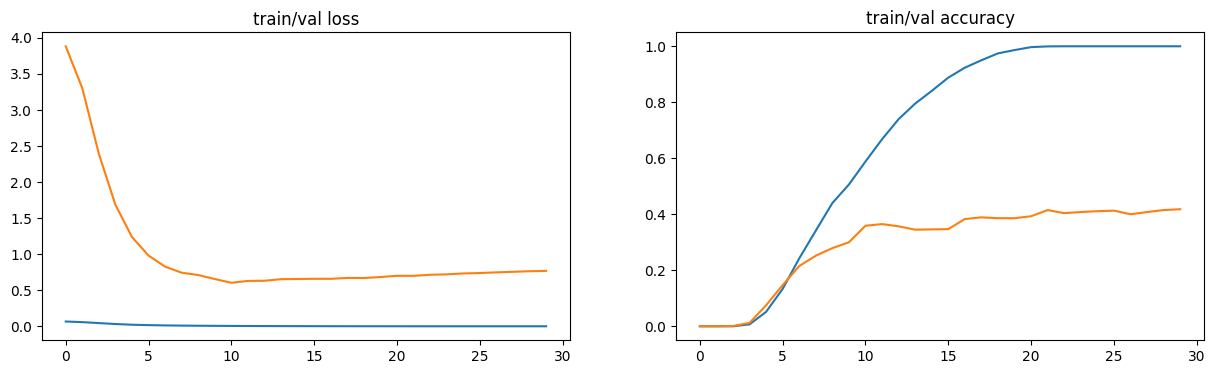

In [11]:
train_loss = checkpoint['train_loss']
val_loss = checkpoint['val_loss']
train_acc = checkpoint['train_acc']
val_acc = checkpoint['val_acc']

fig,axes = plt.subplots(1,2,figsize=(15,4))

axes.flatten()[0].plot(train_loss)
axes.flatten()[0].plot(val_loss)
axes.flatten()[0].set_title('train/val loss')

axes.flatten()[1].plot(train_acc)
axes.flatten()[1].plot(val_acc)
axes.flatten()[1].set_title('train/val accuracy')

In [ ]:
epochs = 50
train_loss = []
train_acc = []
val_loss = []
val_acc = []

for epoch in range(epochs):
    # ============================================ TRAINING =====================================================
    model.train()
    model.to(device)
    
    train_correct = 0
    train_total = 0
    running_train_loss = 0.0
    
    for x_train, y_train in train_loader:
        batch_size = x_train.shape[0]
        x_train = x_train.view(batch_size, 1, x_train.shape[1], x_train.shape[2])

        optimizer.zero_grad()
        y_pred = model(x_train.to(device))
        y_pred = y_pred.permute(1, 0, 2)
        
        input_lengths = torch.IntTensor(batch_size).fill_(cnn_output_width)
        target_lengths = torch.IntTensor([len(t) for t in y_train])
        loss = criterion(y_pred, y_train.to(device), input_lengths, target_lengths)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

        _, max_index = torch.max(y_pred, dim=2)
        for step in range(batch_size):
            raw_prediction = list(max_index[:, step].detach().cpu().numpy())
            prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
            if len(prediction) == len(y_train[step]) and torch.all(prediction.eq(y_train.cpu()[step])):
                train_correct += 1
            train_total += 1
    
    train_average_loss = running_train_loss / len(train_loader.dataset)
    train_accuracy = train_correct / train_total
    train_loss.append(train_average_loss)
    train_acc.append(train_accuracy)
    
    # ============================================ VALIDATION ===================================================
    model.eval()
    val_correct = 0
    val_total = 0
    running_val_loss = 0.0
    
    with torch.no_grad():
        for x_val, y_val in val_loader:
            batch_size = x_val.shape[0]
            x_val = x_val.view(batch_size, 1, x_val.shape[1], x_val.shape[2])
            y_pred_val = model(x_val.to(device))
            y_pred_val = y_pred_val.permute(1, 0, 2)
            input_lengths_val = torch.IntTensor(batch_size).fill_(cnn_output_width)
            target_lengths_val = torch.IntTensor([len(t) for t in y_val])
            loss_val = criterion(y_pred_val, y_val.to(device), input_lengths_val, target_lengths_val)
            running_val_loss += loss_val.item()
            
            _, max_index_val = torch.max(y_pred_val, dim=2)
            for i in range(batch_size):
                raw_prediction_val = list(max_index_val[:, i].detach().cpu().numpy())
                prediction_val = torch.IntTensor([c for c, _ in groupby(raw_prediction_val) if c != blank_label])
                if len(prediction_val) == len(y_val[i]) and torch.all(prediction_val.eq(y_val[i])):
                    val_correct += 1
                val_total += 1
    
    val_average_loss = running_val_loss / len(val_loader.dataset)
    val_accuracy = val_correct / val_total
    val_loss.append(val_average_loss)
    val_acc.append(val_accuracy)
    
    print(f'Epoch [{epoch+1}/{epochs}] Train Loss: {train_average_loss:.4f}, Train Accuracy: {train_correct}/{train_total} = {train_accuracy:.4f}, Val Loss: {val_average_loss:.4f}, Val Accuracy: {val_correct}/{val_total} = {val_accuracy:.4f}')


In [ ]:
# Define paths for saving the model checkpoint
checkpoint_path = "./saved_models/recognizer_8k_8.pth"

# Save the checkpoint
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_loss,
    'train_acc': train_acc,
    'val_loss' : val_loss,
    'val_acc': val_acc
}, checkpoint_path)

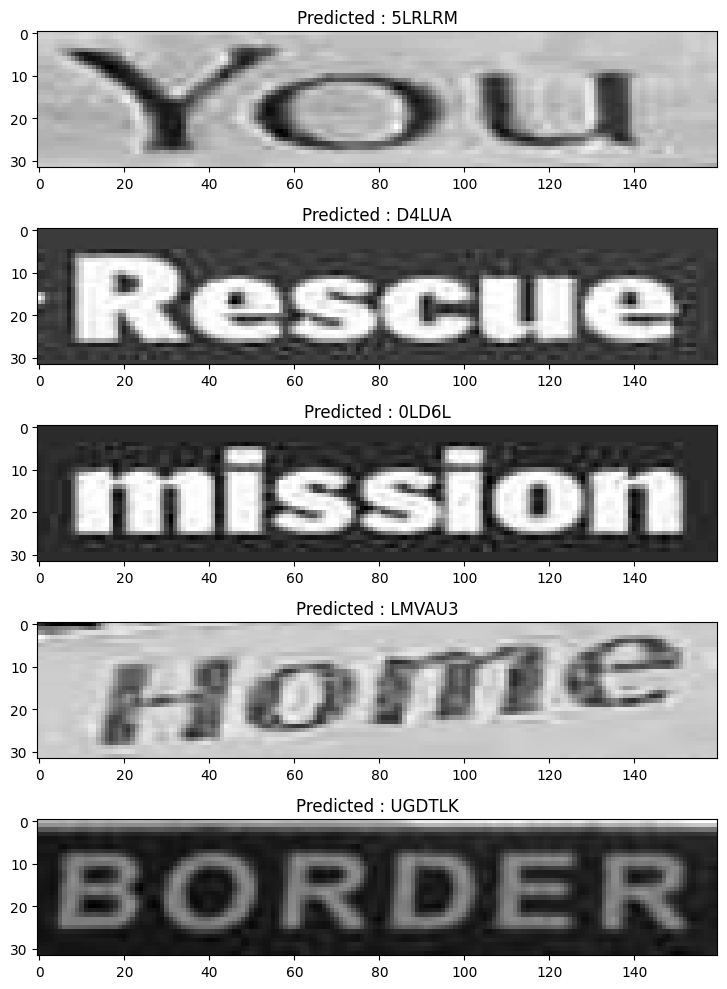

In [12]:
fig, axes = plt.subplots(5,1,figsize=(10,10))

test_sequence_data = []
test_preds = []

for image_file in os.listdir(test_path)[:5]:
    image_path = os.path.join(test_path, image_file)
    img = Image.open(image_path).convert('L')
    img = img.resize((160, 32))
    img = ImageOps.autocontrast(img)
    img = transforms.ToTensor()(img).numpy()
    test_sequence_data.append(img)
    
test_sequence_data = np.array(test_sequence_data)
test_sequence_tensor = torch.from_numpy(test_sequence_data).float().to(device)
y_pred = model(test_sequence_tensor)
y_pred = y_pred.permute(1, 0, 2)
_, max_index = torch.max(y_pred, dim=2)

for i in range(test_sequence_data.shape[0]):
    raw_prediction = list(max_index[:, i].detach().cpu().numpy())
    prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
    test_preds.append(prediction)
    
for j in range(len(test_sequence_data)):
    axes.flatten()[j].imshow(test_sequence_data[j][0], cmap='gray')
    axes.flatten()[j].set_title(f'Predicted : {str(utils.map_result(test_preds[j].numpy()))}')
    
plt.tight_layout()
plt.show()

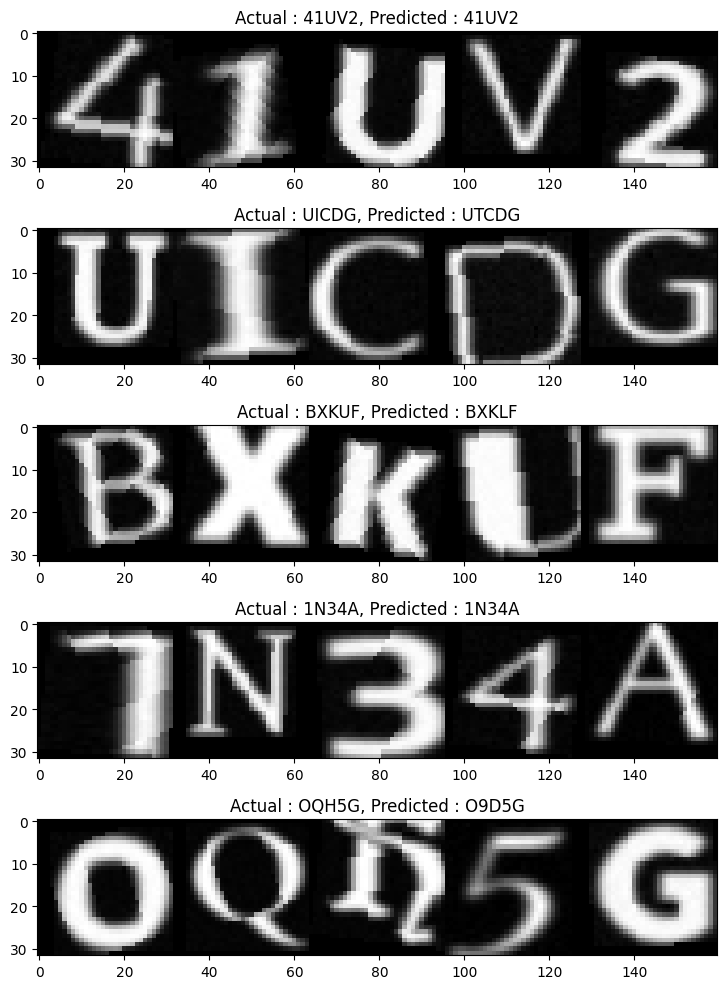

In [13]:
fig, axes = plt.subplots(5,1,figsize=(10,10))

number_of_test_imgs = 5
test_loader = torch.utils.data.DataLoader(val_set, batch_size=number_of_test_imgs, shuffle=True)
test_preds = []
(x_test, y_test) = next(iter(test_loader))
y_pred = model(x_test.view(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2]).cuda())
y_pred = y_pred.permute(1, 0, 2)
_, max_index = torch.max(y_pred, dim=2)
for i in range(x_test.shape[0]):
    raw_prediction = list(max_index[:, i].detach().cpu().numpy())
    prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
    test_preds.append(prediction)

for j in range(len(x_test)):
    axes.flatten()[j].imshow(x_test[j], cmap='gray')
    axes.flatten()[j].set_title(f'Actual : {str(utils.map_result(y_test[j].numpy()))}, Predicted : {str(utils.map_result(test_preds[j].numpy()))}')
    
plt.tight_layout()
plt.show()